# **Cyclades** board game tracking

* Karol Cyganik, 148250
* Sebastian Chwilczyński 148248

In this notebook we will present our solution for the **Cyclades** board game tracking. We will show how we implemented the game logic and how we tracked objects on the board, as well as events.
<br>
This game is for 2-4 players, we similated the game for 3 players. The game is played on board, which can be divided into 2 parts - left, where every player has to bet some money for chosen god, and right, where the game is played. The game is played in turns, where every player can do one of the following actions:
* Bet money for chosen god
* Place a ship on the board
* Place a warrior on the board
* Fight with other player
* Place cities on the board

We decided to record movies with 3 levels of difficulty. It turned out, that even the first one is very hard, corresponding to the level 3 in the project description. There we have an angled view of the board, static camera view and sometimes we cover elements by hand. The second level is harder, as it introduces slightly different angle and different light conditions (random shadows). The third one is almost impossible to process, because we have there a dynamic camera view with a acute angle and random shadows. We also have a lot of objects on the board, which makes it even harder to track.

We decided to track several objects:
* Ships (and their colors)
* Warriors (and their colors)
* Counters (and their colors, for betting)
* Gods' cards
* Circles, which are used to mark the ares we can put ships/warriors on (with their type)
* Islands
* Cities?????

We also track several events:
* Placing ships
* Placing warriors
* Placing gods' cards
* Placing counters for betting
* Placing cities ?????
* Moving ships
* Moving warriors
* Moving counters while betting
* Drawing a card
* Assingning an island to a player

As a gameplay status, and score, we track:
* Total number of ships, and warriors
* Total number of taken islands
* Total number of cities -> an indicator who wins the game?????


## Dataset

### Level 1
As stated above, first level has following conditions:
* Angled view of the board
* No camera shaking
* No random shadows, the light is constant
* Hands are covering some elements, and making a little bit of shadows
  
Example of the frames from the first level of difficulty:

In [9]:
import cv2
import glob
import PIL
from PIL import Image
def get_video(path):
    video = cv2.VideoCapture(path)
    if video.isOpened():
        print('Video loaded')
    video_width = int(video.get(3))
    video_height = int(video.get(4))

    print(video_height, video_width)

    video_fps = video.get(cv2.CAP_PROP_FPS)
    print(video_fps)

    return video, video_width, video_height, video_fps


def get_one_frame(video, frame_num, resize=True):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_num-1)
    res, frame = video.read()
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)

    if resize:
        frame = cv2.resize(frame, None, fx=0.4, fy=0.4)
    return frame


paths = glob.glob('./data/*.mp4')


def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
      if a.shape[2] == 4:
        a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
      else:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))


Video loaded
1080 1920
29.99706778776856


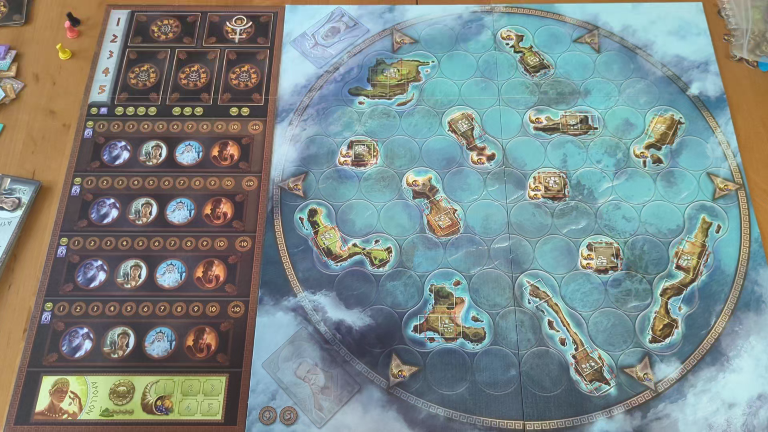

In [21]:
video, width, height, fps = get_video(paths[0])
first_frame1 = get_one_frame(video, 1)
imshow(first_frame1)


Video loaded
1080 1920
30.00340036979813


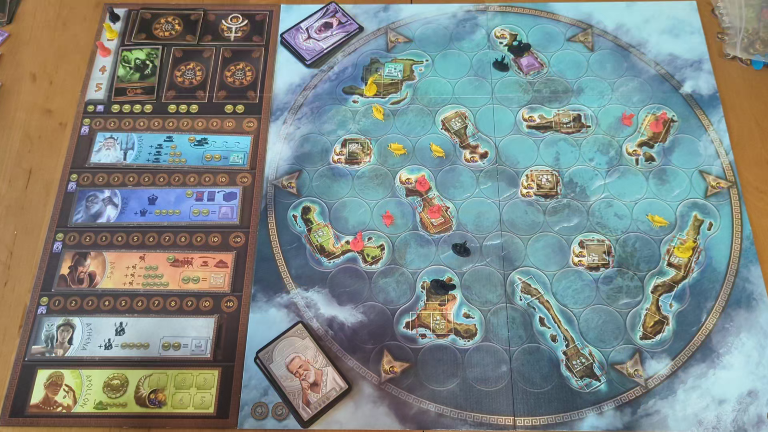

In [44]:
video, width, height, fps = get_video(paths[3])
first_frame2 = get_one_frame(video, 1)
imshow(first_frame2)


### Level 2
Here we introduced random shadows and different light conditions


Video loaded
1080 1920
30.00280214774023


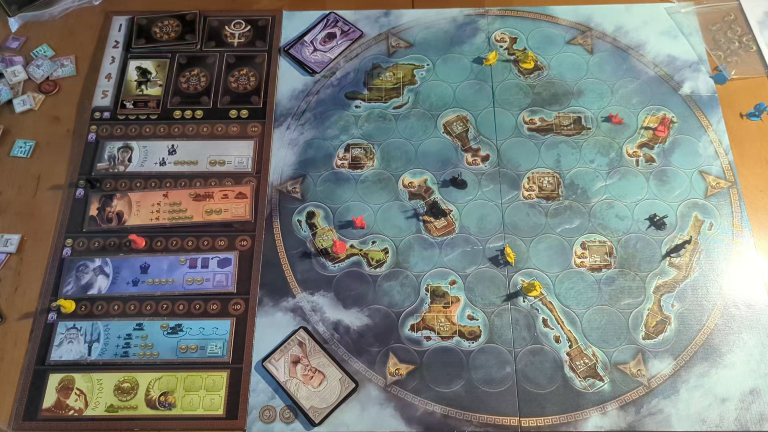

In [14]:
video, width, height, fps = get_video(paths[6])
first_frame = get_one_frame(video, 1)
imshow(first_frame)


Video loaded
1080 1920
30.001106858468077


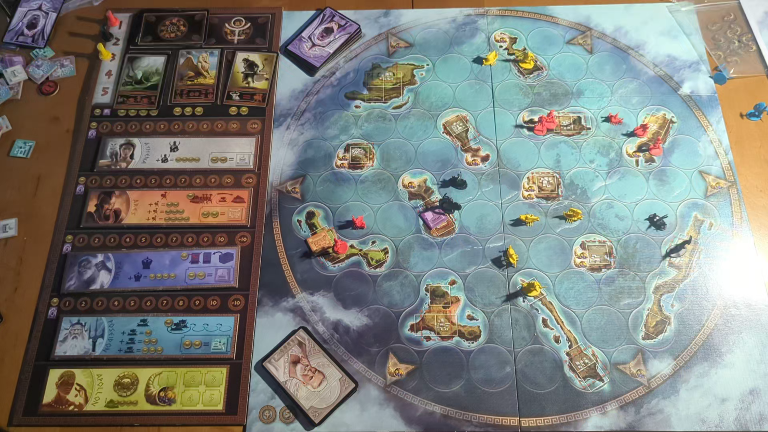

In [13]:
video, width, height, fps = get_video(paths[7])
first_frame = get_one_frame(video, 1)
imshow(first_frame)


### Level 3

Here we introduced dynamic camera view, and random shadows. We also have a lot of objects on the board, which makes it even harder to track.

Video loaded
1080 1920
29.997077435457427


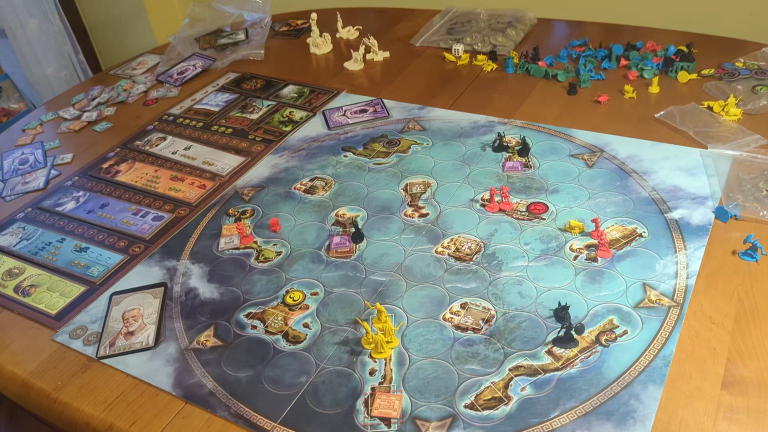

In [15]:
video, width, height, fps = get_video(paths[9])
first_frame = get_one_frame(video, 1)
imshow(first_frame)


Video loaded
1080 1920
29.997088463439265


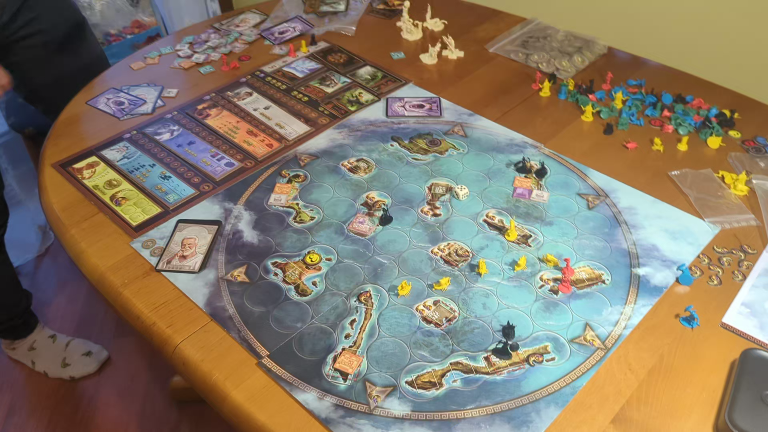

In [16]:
video, width, height, fps = get_video(paths[10])
first_frame = get_one_frame(video, 1)
imshow(first_frame)


## Milestone 1 - first experiments with dataset

First we tried 2 different games, but eventually we sticked with the Cyclades, so we'll show only those examples here. Firstly, we tried to divide the board to two parts

##### Trying to divide board on 2 parts

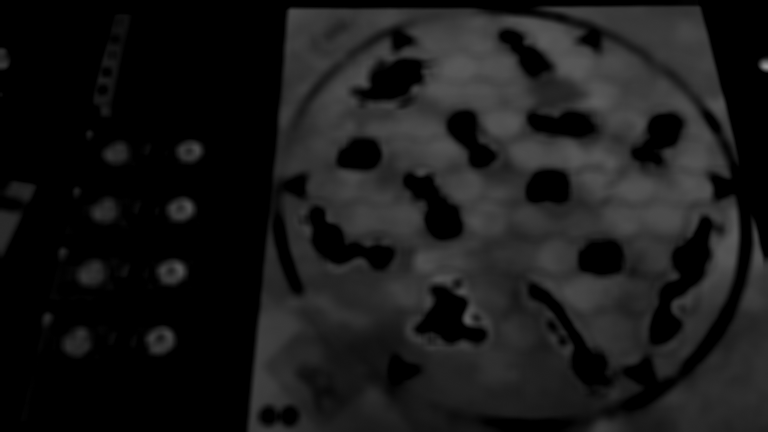

In [22]:
import numpy as np
g = np.ones((10, 10))/100
g2 = -np.ones((10, 10))/100

#g= np.array([[1/3,0],[1/3,0],[1/3,0]])
#g2= np.array([[0,-1/3],[0,-1/3],[0,-1/3]])

fg_cv = cv2.filter2D(first_frame1[:, :, 0], -1, g)
fg_cv2 = cv2.filter2D(first_frame1[:, :, 2].astype(g2.dtype), -1, g2)
imshow(np.maximum(np.zeros_like(fg_cv), fg_cv + fg_cv2))


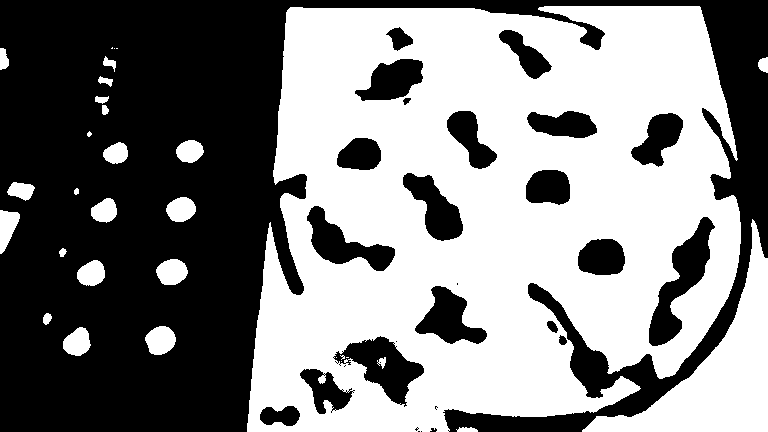

In [23]:
imshow((np.maximum(np.zeros_like(fg_cv), fg_cv + fg_cv2) > 20) * 255)


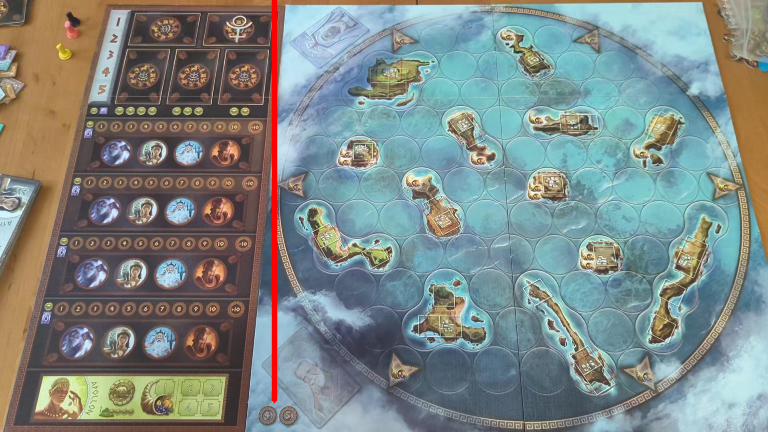

In [24]:
mask = (np.maximum(np.zeros_like(fg_cv), fg_cv + fg_cv2) > 20).sum(axis=0)
indicator = np.where(mask > 300)[0][0]
dst = first_frame1.copy()
dst = cv2.line(dst, (indicator-10, 0), (indicator-10, 400),
               (0, 0, 255), 3, cv2.LINE_AA)
imshow(dst)


##### Find circles

Then, we tried to detect circles on the board.

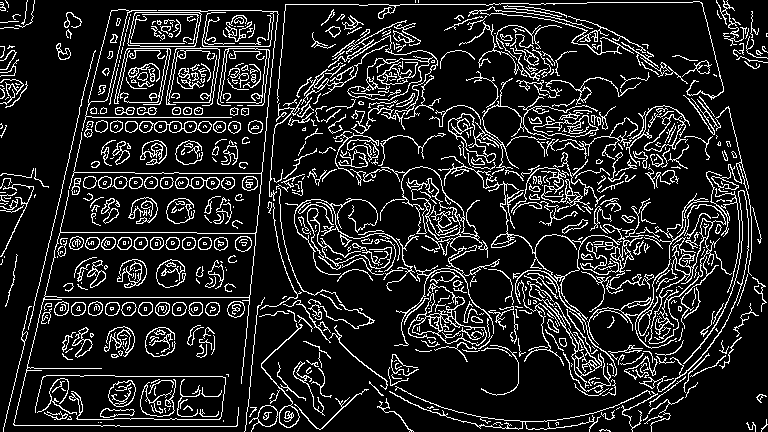

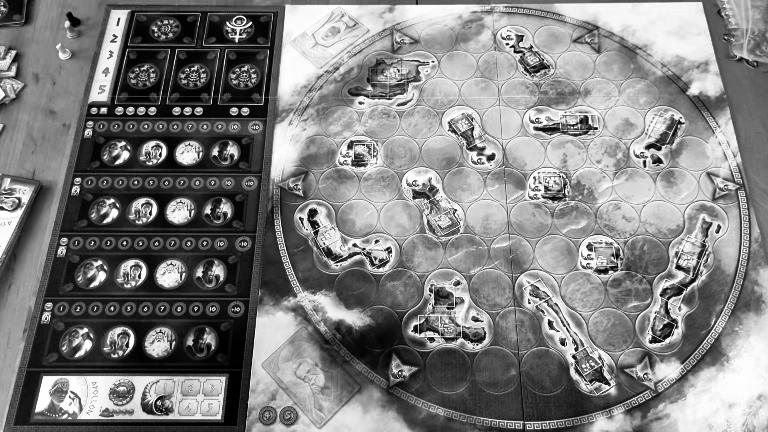

In [28]:
def find_circles(frame, equalize="local", blur=False, **kwargs):
    cframe = frame.copy()
    if frame.ndim == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if blur:
        frame = cv2.GaussianBlur(frame, (3, 3), 0)
    if equalize == "global":
        frame = cv2.equalizeHist(frame)
    elif equalize == "local":
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        frame = clahe.apply(frame)

    circles = cv2.HoughCircles(
        frame, cv2.HOUGH_GRADIENT, 1, **kwargs)
    circles = np.uint16(np.around(circles))

    return circles


def detect_edges(frame, equalize=True, blur=False, low_threshold=70, high_threshold=190):
    if frame.ndim == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if blur:
        frame = cv2.GaussianBlur(frame, (3, 3), 0)
        frame = cv2.GaussianBlur(frame, (3, 3), 0)
    if equalize:
        frame = cv2.equalizeHist(frame)
    edges = cv2.Canny(frame, low_threshold, high_threshold, apertureSize=3)
    return edges


imshow(detect_edges(first_frame, blur=True))


def draw_circles(frame, circles, maps):
    for i, map in zip(circles[0, :], maps):
        # draw the outer circle
        if map == "sea":
            cv2.circle(frame, (i[0], i[1]), i[2], (255, 0, 0), 2)
        elif map == "land":
            cv2.circle(frame, (i[0], i[1]), i[2], (0, 255, 0), 2)
        else:
            cv2.circle(frame, (i[0], i[1]), i[2], (0, 0, 255), 2)
        # draw the center of the circle
        #cv2.circle(frame, (i[0], i[1]), 2, (0, 0, 255), 3)
    return frame


imshow(cv2.equalizeHist(cv2.cvtColor(first_frame1, cv2.COLOR_BGR2GRAY)))


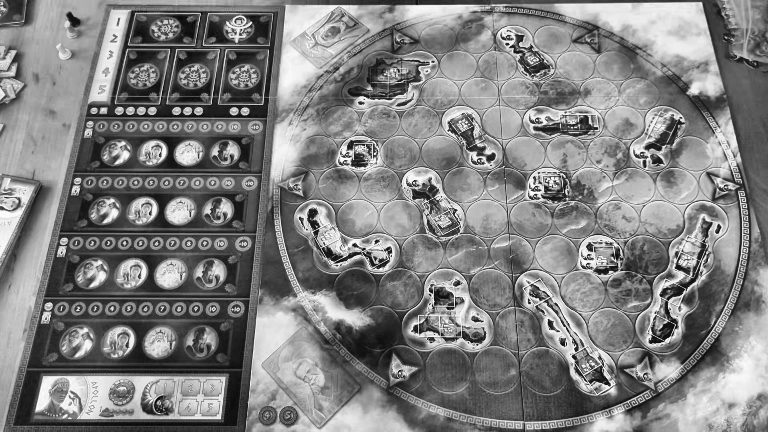

In [29]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
imshow(clahe.apply(cv2.cvtColor(first_frame1, cv2.COLOR_BGR2GRAY)))


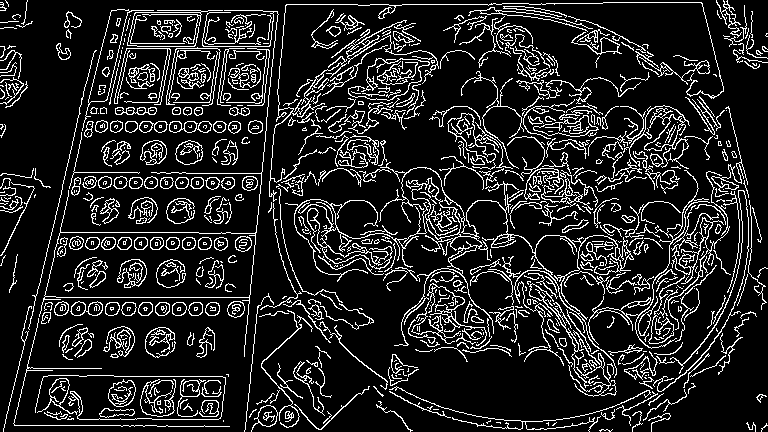

In [32]:
imshow(detect_edges(cv2.equalizeHist(cv2.cvtColor(
    first_frame1, cv2.COLOR_BGR2GRAY)), 100, 200))


Firs part of hough circles is canny edge detection so this is a good  idea to visualize how this would look to Circle detector
<br>


In [37]:
#Interestingly using 2nd channel gives the best results
#imshow(find_circles(first_frame2, equalize="local", minDist=30, param1=170, param2=20, minRadius=12, maxRadius=25))
#imshow(find_circles(first_frame2, equalize=False, minDist=30, param1=170, param2=20, minRadius=10, maxRadius=25))


def segment_by_hsv_color(frame, lower, upper, plot=False):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # if plot:
    #     plot_colors(lower, upper)

    mask = cv2.inRange(hsv, lower, upper)

    return mask


circles = find_circles(first_frame1, equalize="local", minDist=30,
                       param1=170, param2=20, minRadius=12, maxRadius=25)
maps = []
for circle in circles[0, :]:
    x, y, r = circle
    if x > 290:
        x1, y1 = x - r, y - r
        x2, y2 = x + r, y + r
        circle[2] = 19
        place = first_frame1[y1:y2, x1:x2]
        sea_mask = segment_by_hsv_color(place, np.array(
            [50, 50, 50]), np.array([110, 255, 255]), plot=False)
        land_mask = segment_by_hsv_color(place, np.array(
            [10, 50, 50]), np.array([49, 255, 255]), plot=False)
        total = (x2-x1) * (y2-y1) * 255
        sea_ratio = np.sum(sea_mask) / total
        land_ratio = np.sum(land_mask) / total

        if land_ratio > 0.08:
            maps.append("land")
            #print("LAND")
        elif sea_ratio > 0.7:
            #print("SEA")
            maps.append("sea")
        else:
            maps.append("nothing")

    else:
        maps.append("nothing")


first_frame1.shape


(432, 768, 3)

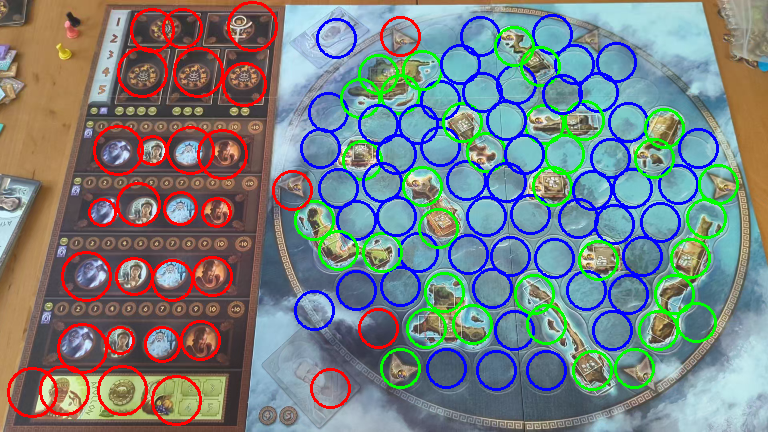

In [38]:
imshow(draw_circles(first_frame1.copy(), circles, maps))


##### Color segmentation

We try simple color masks on HSV color space. It worked quite well, but we had to use a lot of masks.

In [46]:
from matplotlib.colors import hsv_to_rgb
from matplotlib import pyplot as plt

def plot_colors(hsv1, hsv2):
    square1 = np.full((10, 10, 3), hsv1, dtype=np.uint8) / 255.0
    square2 = np.full((10, 10, 3), hsv2, dtype=np.uint8) / 255.0
    plt.imshow(hsv_to_rgb(np.concatenate([square1, square2], axis=0)))


def segment_by_hsv_color(frame, lower, upper, plot_colors=False):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    if plot_colors:
        plot_colors(lower, upper)

    mask = cv2.inRange(hsv, lower, upper)

    return mask


yellow_segmented = segment_by_hsv_color(
    first_frame2, np.array([20, 160, 160]), np.array([30, 255, 255]))
red_segmented = segment_by_hsv_color(first_frame2, np.array(
    [150, 100, 100]), np.array([180, 255, 255]))


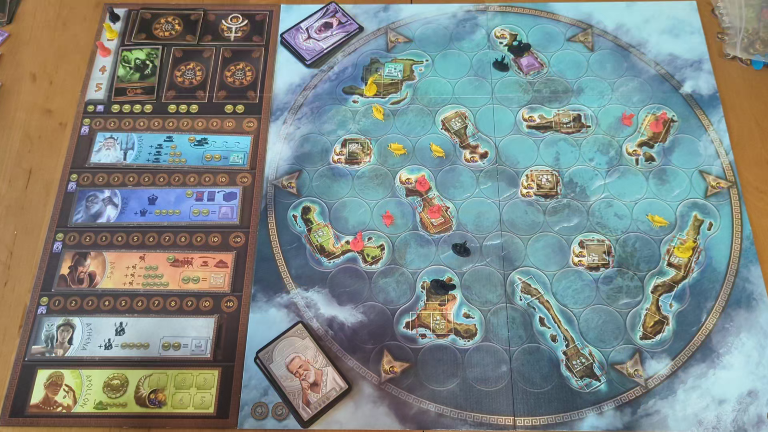

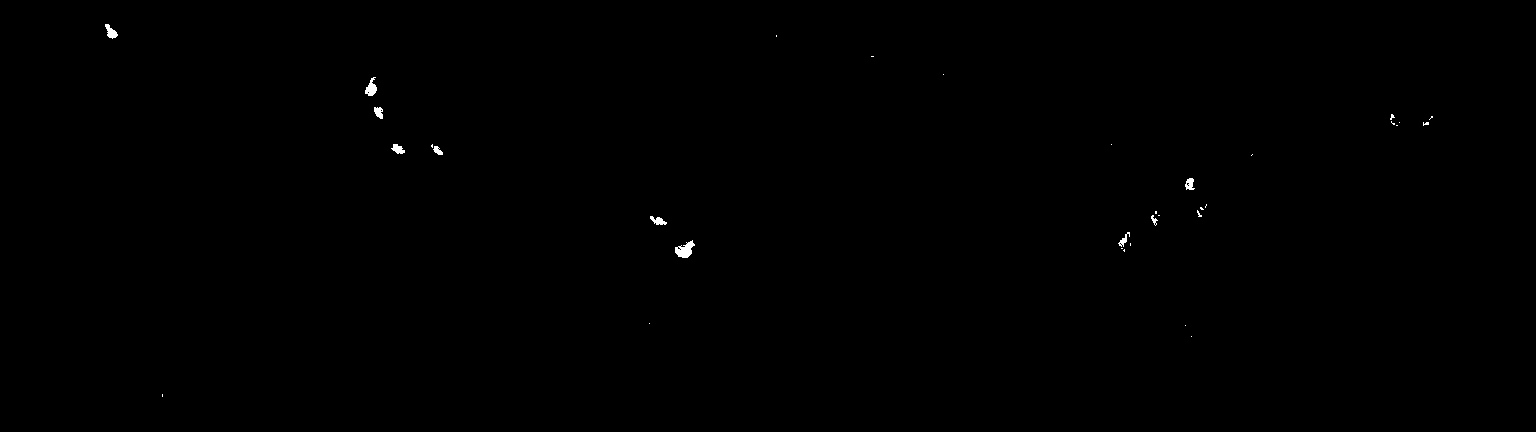

In [47]:
imshow(first_frame2)
imshow(np.concatenate([yellow_segmented, red_segmented], axis=1))


## Frame processing pipeline

### Pre and first frame processing

Firstly we read the video from given path, get the first frame and preprocess it in order to use it further.<br>
First preprocess step is to cut the left background and set the mask. We do it by finding Hough line dividing the board, and then setting the mask on the left to the "border" to 0.<br><br>
Then, we initialize the first part. We equalize the colors in the image, and resize the frame. We also separete the frame into 2 parts using previously calculated separating line.  We also initialize key points and descriptors for the first frame in order to use it later in the tracking process. <br><br>

In [53]:
def get_mask_of_left_mess(self):
    # Cut of the left background

    edges = cv2.Canny(cv2.medianBlur(
        self.empty_board_color, 3), 200, 250, apertureSize=3)
    linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, None, 400, 20)
    line = linesP[0][0]
    bounding_points = np.linspace(
          line[2]-5, line[3]-5, self.empty_board_color.shape[0]).astype(np.uint8)

    mask = np.ones_like(self.empty_board_gray)
    for i, boundary in enumerate(bounding_points):
        mask[i, :boundary] = 0

    self.mask = mask


Here we find the cirles too. The method is described above, we equalize the image using CLAHE, and then detect the Hough Circles. After finding the cirles on the board we label them using heuristics based on color segmentation. We take colors for land, and water, and calculate the ratio to use them later to label the circles. We also use the ratio to label the islands later on - it'll be discussed later, but that's why we create the variable `segmented_right_part`. <br><br>

In [56]:
import utils
def label_circles(self, circles, frame):
    self.segmented_right_part = frame.copy()
    labeled_circles = []
    for circle in circles[0, :]:
        x, y, r = circle
        # making square out of a circle
        x1, y1 = max(int(x) - r, 0), max(int(y) - r, 0)
        x2, y2 = x + r, y + r
        place = frame[y1:y2, x1:x2]

        sea_mask = utils.segment_by_hsv_color(
            place, np.array([50, 50, 50]), np.array([110, 255, 255]))
        land_mask = utils.segment_by_hsv_color(
            place, np.array([10, 50, 50]), np.array([49, 255, 255]))

        total = (x2-x1) * (y2-y1) * 255
        sea_ratio = np.sum(sea_mask) / total
        land_ratio = np.sum(land_mask) / total

        if land_ratio > 0.08:
            labeled_circles.append((circle, "land"))
            self.segmented_right_part[y1:y2, x1:x2] = (0, 255, 0)
        elif sea_ratio > 0.7:
            labeled_circles.append((circle, "sea"))
            self.segmented_right_part[y1:y2, x1:x2] = (255, 0, 0)


After finding circles we initialize probably the most important part in case of tracking objects - background extraction. We use knn foreground extractor, which is a simple algorithm, but it works quite well. We also initialize the background extractor with the first frame, and then we use it to extract the background from the first frame. <br><br>



In [57]:
video, width, height, fps = get_video(
    paths[3])  # !height and width are reversed!
foreground_knn_vid = cv2.VideoWriter(
    'cyclades_cut_foreground_knn.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height), 0)
foreground_mog2_vid = cv2.VideoWriter(
    'cyclades_cut_foreground_mog2.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height), 0)

foreground_knn = cv2.createBackgroundSubtractorKNN()
foreground_mog2 = cv2.createBackgroundSubtractorMOG2()

video.set(cv2.CAP_PROP_POS_FRAMES, 0)
while video.isOpened():
  ret, frame = video.read()
  if ret:
    foreground_knn_vid.write(foreground_knn.apply(frame))
    foreground_mog2_vid.write(foreground_mog2.apply(frame))
  else:
    break

foreground_knn_vid.release()
foreground_mog2_vid.release()
foreground, width, height, fps = get_video("cyclades_cut_foreground_knn.avi")


Video loaded
1080 1920
30.00340036979813
Video loaded
1080 1920
30.003


Lastly, we detect all islands. As stated before, we used previous heuristic here - we segmented the board in the way, that we color all water segments in blue, and all land segments in green. We masked simply the green color there. Then, we use some erosion and dilation to clean the image and connect one island's components. After this step we're ready to find the islands' contours. Then we filter out 2 islands by area, as they appeared as one in a V-shape, which destroyed the image readability. We use elipsis to bound the islands later on, we store the contours and rectangle boundary for this purpose<br><br>

In [55]:
def detect_islands(self, frame):
    land_mask = utils.segment_by_hsv_color(
        self.segmented_right_part, np.array([50, 50, 50]), np.array([70, 255, 255]))
    land_mask = cv2.erode(land_mask, np.ones((3, 3)), iterations=1)
    land_mask = cv2.dilate(land_mask, np.ones((3, 3)), iterations=6)
    cnts, hier = cv2.findContours(
          land_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    islands = {}
    for cnt in cnts:
        if cv2.contourArea(cnt) > 10000:
            continue
        if cnt.shape[0] > 5:
            xr, yr, wr, hr = cv2.boundingRect(cnt)
            islands[(xr, yr, wr, hr)] = [cnt]
    return islands


### Each frame processing

We iterate over **10** frames, which gives 3FPS. <br><br>

For each frame we do the same steps as above, we resize it and equalize color in the frame.<br><br>

Then we try to align current frame to the first frame using previously calculated keypoints and descriptors. We use ORB detector and descriptor, and then we use Brute Force matcher to find the best matches. We find, and use homography to warp the perspective

In [ ]:
def alignImageToFirstFrame(self, im_gray, im_color):
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(self.MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im_gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(
        cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(
        descriptors1, self.first_frame_desc, None))

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    # Remove not so good matches
    numGoodMatches = int(len(matches) * self.GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = self.first_frame_key[match.trainIdx].pt

    # Find and use homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    height, width, channels = self.first_frame_color.shape
    im1Reg = cv2.warpPerspective(im_color, h, (width, height))

    return im1Reg


Then, we separete the frame using previously calculated separating line. We use foreground extraction, which is further also divided to 2 parts.

In [62]:
def beggining_of_processing_frame():
    self.left_part_color, self.right_part_color = self.separate(
        frame_color)

    foreground = self.foreground_knn.apply(
        cv2.GaussianBlur(frame_color, (3, 3), 0))
    foreground = cv2.morphologyEx(foreground, cv2.MORPH_OPEN, np.ones(
        (7, 7), dtype=np.uint8)) * self.mask  # To filter defined background we multiply by mask
    # To have only very intense foreground
    foreground = ((foreground > 200) * 255).astype(np.uint8)
    foreground_left, foreground_right = self.separate(foreground)


Now the most important part takes plase. We look and update the interesting objects for both left, and right side of the board, but separately. <br><br>

In [64]:
#CODE, cały update stanów

After updating the state we want to updae the view, to have every information on the screen.

In [65]:
#CODE self.update_view()


## Results on each dataset

(python video player with results)

## Conclusion

# TODO
* uzupełnić jak robimy podział planszy i kółka
* 